Till now we've used three inputs to predict the next character in this project. In previous notebook, we've followed and implemented bengio's MLP architecture with a index lookup for inputs, hiddent layers and single activation layer.

A single activation layer compresses lots of information. To overcome this next we're going to implement [Wavenet architecture from this paper](https://arxiv.org/pdf/1609.03499.pdf).

An autoregressive model.

# Makemore: Part5

## Starter code

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('/Users/jayaprakashsivagami/Documents/Tech/ML/makemore/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffling up words
import random
random.seed(42)
random.shuffle(words)

In [13]:
# build the dataset
block_size = 3 # context lenght: how many character do we take to predict next time?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [5]:
# Layes developed in part 3
# ------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
# ------------------------------------------------------
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
# ------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [9]:
torch.manual_seed(42) # seed for reproducability

In [10]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

12097


In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters to vectors
    x = emb.view(emb.shape[0], -1) # concat layers
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backeward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2418
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


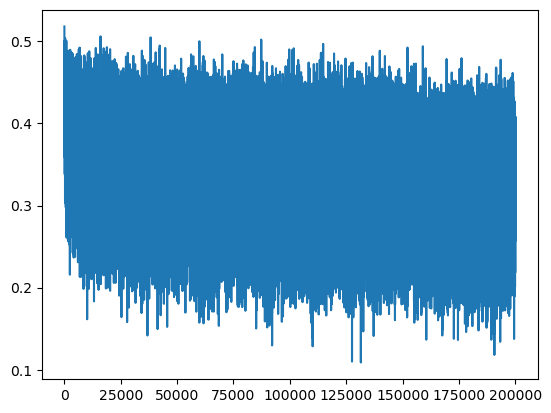

In [12]:
plt.plot(lossi)

In [13]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

In [14]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065292358398438


In [15]:
# sample from model

for _ in range(20):
    
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift context window and tract samples
        context = context[1:] + [ix]
        out.append(ix)
        # if '.' break
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.


## Fixing learning rate loss plot

Loss we've right is for every step as a list.

Let's take a mean of certain number of steps(1000) for better visualization.

In [16]:
lossi = torch.tensor(lossi)
lossi.shape

torch.Size([200000])

In [18]:
lossi.view(-1, 1000).shape

torch.Size([200, 1000])

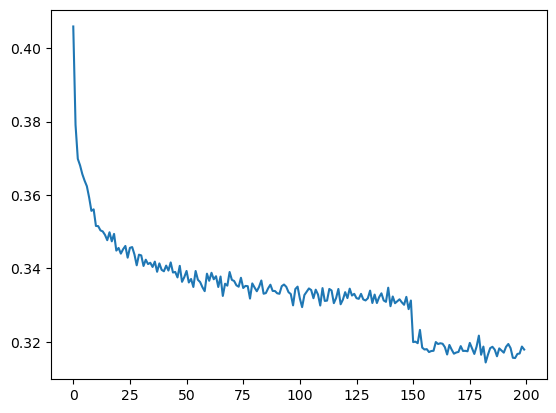

In [20]:
plt.plot(lossi.view(-1, 1000).mean(1));

Now the plot looks good and we can observe a large dip in loss at learning rate decay.

## PyTorchifying layers, containers, torch.nn

In our forward pass, we've few steps outside the layers...
    1. embedding index lookup for characters
    2. Flattening of embeddings(because view is cheap in pytorch  in terms of memory)

Let's create layers for these

In [21]:
### Embedding and Flatten Layers

In [6]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

Replace paramters and forward path with above layers

In [41]:
n_embd = 10
n_hidden = 200

# C = torch.randn((vocab_size, n_embd))
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

12097


In [42]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backeward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3097


We've simplified the forward pass using embedding and flatten layers. Still our layers are present in a naked list.
We can improve this by using torch.nn.containers, specifically we're going to model [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) in our code.

In [7]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Replace naked list of layers with Sequential

In [224]:
n_embd = 10
n_hidden = 200

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

12097


In [225]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000: 3.5196
  10000/ 200000: 2.2744
  20000/ 200000: 1.7095
  30000/ 200000: 2.3500
  40000/ 200000: 2.3996
  50000/ 200000: 2.4342
  60000/ 200000: 2.1319
  70000/ 200000: 2.2053
  80000/ 200000: 2.1118
  90000/ 200000: 2.7002
 100000/ 200000: 2.3265
 110000/ 200000: 2.1934
 120000/ 200000: 2.0324
 130000/ 200000: 2.0732
 140000/ 200000: 2.0728
 150000/ 200000: 2.4909
 160000/ 200000: 1.9058
 170000/ 200000: 1.7504
 180000/ 200000: 2.4556
 190000/ 200000: 2.1987


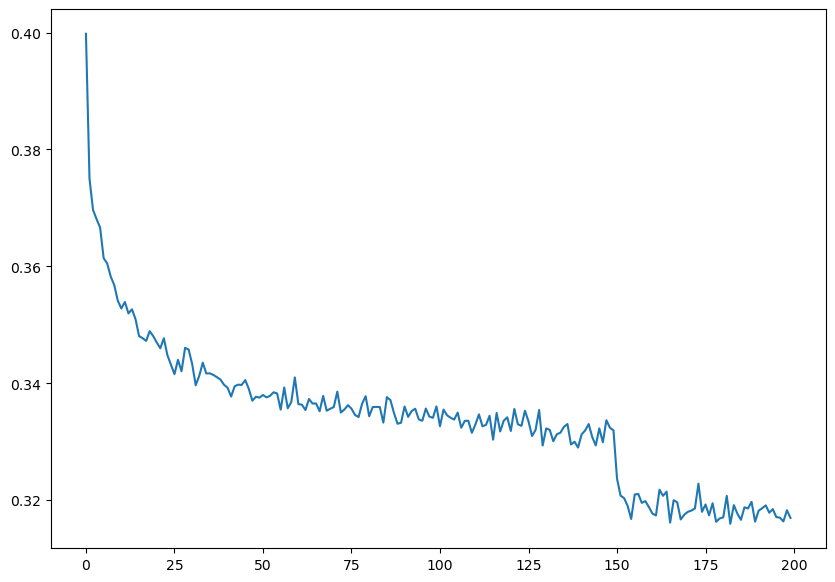

In [226]:
plt.figure(figsize=(10, 7))
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1));

In [227]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [8]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    return loss.item()

# split_loss('train')
# split_loss('val')

In [229]:
# sample from model

for _ in range(20):
    
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        # forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift context window and tract samples
        context = context[1:] + [ix]
        out.append(ix)
        # if '.' break
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

zarish.
zakalianah.
lameelekson.
lucintlee.
stenzel.
aajeen.
dai.
alestie.
ossanuschera.
sophin.
yeeden.
koline.
nervi.
jete.
triston.
bradiette.
kayde.
eunoah.
ham.
makelaylorie.


In [71]:
# Tracking experiments with mlflow
import mlflow
def log_experiment(run_name,test_loss=None):
    mlflow.set_experiment("wavenet")
    mlflow.end_run()
    mlflow.start_run(run_name=run_name)
    mlflow.log_param("Character context", block_size)
    mlflow.log_param("Hidden neurons", n_hidden)
    mlflow.log_param("Total params", sum(p.nelement() for p in parameters))
    mlflow.log_metric("TrainLoss", float(format(split_loss('train'), '.4f')))
    mlflow.log_metric("ValLoss", float(format(split_loss('val'), '.4f')))
    if test_loss:
        mlflow.log_metric("TestLoss", split_loss('test'))
    mlflow.end_run()

In [231]:
log_experiment(run_name="bengio")

train 2.0594840049743652
val 2.106677532196045


We're gonna use mlfow to track our experiments and will be saving screenshots of mlflow UI.

![Alt wn1](images/tracking/wn1.png)

## Overview of wavenet

Currently we're using bengio's below fully connected *mlp architecture*
![fully connected MLP](https://pbs.twimg.com/media/Fhzl42hVUAI9U8V?format=jpg&name=large)

Since the validation loss is close to training loss, we're not overfitting the model. Based on this we can scale up our model using the build blocks.
But creating a much deeper layer wiht just a single hidden layer will compress all this information and will be led to waste like we discussed at the beginning of this notebook.

*Wavenet Architecture*
![Wavenet architecture](https://miro.medium.com/v2/format:webp/1*tiZ-jX0ECHwEysGWjzkzDA.png)

Following this architecture, Instead of a single activation... At each level we mrege two consecutive elements in a tree like structure. 
For example
    * Start with a bigram
    * merge the output of inital bigram output with next bigram output
    * Then merge two four grams and so on...

Whic

## Dataset context size to 8

In [108]:
# build the dataset
block_size = 8 # context lenght: how many character do we take to predict next time?

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [233]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


All other stuff should work fine

In [11]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

22097


In [235]:
# Crushing way too much information (context size 8) way too fast
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000: 3.4702
  10000/ 200000: 2.2046
  20000/ 200000: 2.1719
  30000/ 200000: 2.1758
  40000/ 200000: 2.0847
  50000/ 200000: 2.1159
  60000/ 200000: 2.4074
  70000/ 200000: 1.9093
  80000/ 200000: 1.5154
  90000/ 200000: 1.9425
 100000/ 200000: 2.1548
 110000/ 200000: 1.6961
 120000/ 200000: 2.1540
 130000/ 200000: 1.9238
 140000/ 200000: 2.0179
 150000/ 200000: 1.8580
 160000/ 200000: 1.6177
 170000/ 200000: 1.8320
 180000/ 200000: 1.7522
 190000/ 200000: 2.3777


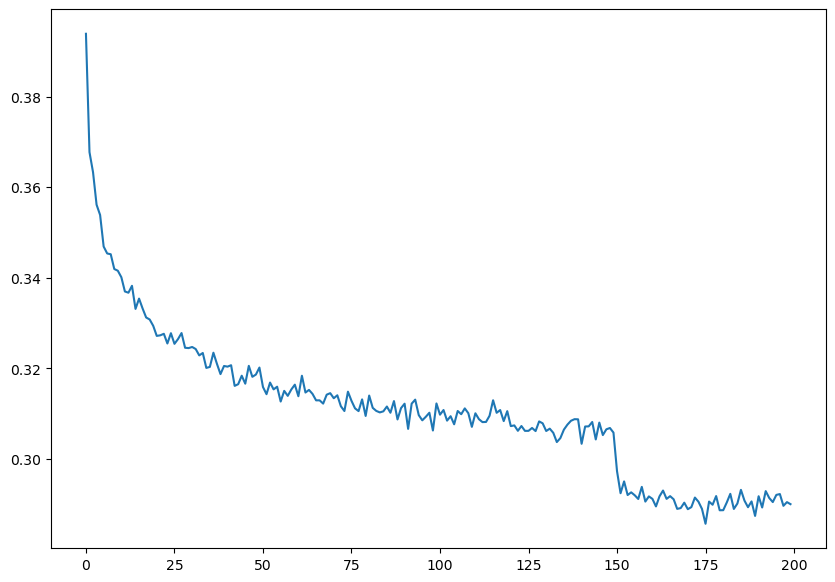

In [236]:
plt.figure(figsize=(10, 7))
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1));

In [237]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [238]:
# evaluate the loss
split_loss('train')
split_loss('val')

train 1.9225822687149048
val 2.025252342224121


2.025252342224121

In [239]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        # forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift context window and tract samples
        context = context[1:] + [ix]
        out.append(ix)
        # if '.' break
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

daeveen.
aeren.
jilton.
ostyn.
keylan.
andeline.
karida.
hissint.
marti.
nakhie.
lainbeth.
tracian.
framaed.
ayveon.
scolton.
aalanee.
nohaya.
sareac.
store.
iniir.


In [240]:
log_experiment(run_name="wavenet-baseline")

train 1.9225822687149048
val 2.025252342224121


![Alt wn2](images/tracking/wn2.png)

We're gonna use bengio mlp with context size of 8 as baseline for our wavenet model.

We can still tweak hyperparameters(no of hidden layers, n_hidden, n_embd, context_size, leraning_rate etc..) and improve the model but let's move on to wavenet and follow the material in place.

## Implementing WaveNet

Writing some scratch space code to look at shapes through layers.

In [15]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Looking at batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 20, 25, 18,  5,  5],
        [ 0,  0,  0,  1, 14,  7,  5, 12],
        [ 0,  0,  0,  0, 20, 25, 12,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 18]])

In [16]:
model.layers[0].out.shape # output of embedding layer

torch.Size([4, 8, 10])

In [17]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [18]:
model.layers[2].out.shape # output of linear layer

torch.Size([4, 200])

In [25]:
# Recap what's happening in Linear layer
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [26]:
# But for WaveNet we don't want this.
# We want to pass bigrams of input and multiply them in linear layer
# (1 2) (3 4) (5 6) (7 8)
# we'll leverage PyTorch's powerful matrix multiplication and add additional batch shape

In [27]:
# Passing 4 batch of 2 characters
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [28]:
# To achieve this we need to update Linear and Flatten layer
e = torch.randn(4, 8, 10) # Goal --> (4, 4, 20) where consecutive 10-d vectors get concatenated

In [32]:
# We can do this in tw ways
# 1. Using slicing
list(range(10))[::2], list(range(10))[1::2]
# Get all even indices, Get all odd indices

([0, 2, 4, 6, 8], [1, 3, 5, 7, 9])

In [39]:
# Using above let's slice
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

Working out a single concatenation

In [42]:
explicit[0, 0]

tensor([-0.0297,  1.5781,  0.8684,  0.8899, -1.3941, -0.8078,  0.8410, -0.4110,
        -0.3129,  2.0421,  1.1649,  0.3412, -0.6721,  1.6170,  0.0773,  0.3181,
        -1.1639,  1.7170,  0.2865,  0.0351])

In [47]:
e[0, 0], e[0, 1]

(tensor([-0.0297,  1.5781,  0.8684,  0.8899, -1.3941, -0.8078,  0.8410, -0.4110,
         -0.3129,  2.0421]),
 tensor([ 1.1649,  0.3412, -0.6721,  1.6170,  0.0773,  0.3181, -1.1639,  1.7170,
          0.2865,  0.0351]))

In [48]:
(torch.cat([e[0, 0], e[0, 1]]) == explicit[0, 0]).all()

tensor(True)

Index of 0 and 1 along second dimension is concatenated along the row!

In [49]:
# Second method using view
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [52]:
# Updating Flatten layer --> This diverges from PyTorch's Flatten
class FlattenConsecutive:

    def __init__(self, n):
        """
        Flatten layer to flatten inputs
        n(int): number of inputs to be concatenated at last dimension
        """
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)

        # In previous case where we concatenated all the embeddings together
        # This setup will create a spurious dimension
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [53]:
n_embd = 10
n_hidden = 200

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(8), # Using previous setup of combining all inputs
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

22097


In [54]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Looking at batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 1, 11,  5, 14,  4, 18,  9,  3],
        [ 0,  0,  0,  0,  2, 18,  1, 25],
        [ 0,  0,  0,  0,  0, 17, 21,  9],
        [ 0,  0, 18,  1, 25, 13, 21, 14]])

In [58]:
for layer in model.layers:
    print(f"Layer Name --> {layer.__class__.__name__} | shape --> {layer.out.shape}")

Layer Name --> Embedding | shape --> torch.Size([4, 8, 10])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 80])
Layer Name --> Linear | shape --> torch.Size([4, 200])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 200])
Layer Name --> Tanh | shape --> torch.Size([4, 200])
Layer Name --> Linear | shape --> torch.Size([4, 27])


In [59]:
# Shape 4, 4, 20 in flatten
n_embd = 10
n_hidden = 200

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

170897


In [62]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Looking at batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0,  0,  0,  0,  0,  1, 12],
        [ 0,  1,  2,  9,  7,  1,  9, 12],
        [ 0,  0,  1, 18, 18,  9,  5, 12]])

In [63]:
for layer in model.layers:
    print(f"Layer Name --> {layer.__class__.__name__} | shape --> {layer.out.shape}")

Layer Name --> Embedding | shape --> torch.Size([4, 8, 10])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 4, 20])
Layer Name --> Linear | shape --> torch.Size([4, 4, 200])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 4, 200])
Layer Name --> Tanh | shape --> torch.Size([4, 4, 200])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 2, 400])
Layer Name --> Linear | shape --> torch.Size([4, 2, 200])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 2, 200])
Layer Name --> Tanh | shape --> torch.Size([4, 2, 200])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 400])
Layer Name --> Linear | shape --> torch.Size([4, 200])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 200])
Layer Name --> Tanh | shape --> torch.Size([4, 200])
Layer Name --> Linear | shape --> torch.Size([4, 27])


Now we've implemented the wavenet architecture for 9 characters.

## Training: First Pass

In [74]:
# Shape 4, 4, 20 in flatten
n_embd = 10
n_hidden = 68 # 200 --> 68 to get 22397 parameters

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

22397


In [75]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Looking at batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 18,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  4,  5],
        [13,  1, 12,  1,  9, 10,  1,  8]])

In [76]:
# Let's check the shapes
for layer in model.layers:
    print(f"Layer Name --> {layer.__class__.__name__} | shape --> {layer.out.shape}")

Layer Name --> Embedding | shape --> torch.Size([4, 8, 10])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 4, 20])
Layer Name --> Linear | shape --> torch.Size([4, 4, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 4, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 4, 68])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 2, 136])
Layer Name --> Linear | shape --> torch.Size([4, 2, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 2, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 2, 68])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 136])
Layer Name --> Linear | shape --> torch.Size([4, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 68])
Layer Name --> Linear | shape --> torch.Size([4, 27])


In [77]:
# Crushing way too much information (context size 8) way too fast
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000: 3.3040
  10000/ 200000: 2.3826
  20000/ 200000: 1.9416
  30000/ 200000: 1.9598
  40000/ 200000: 2.1018
  50000/ 200000: 2.0285
  60000/ 200000: 2.1334
  70000/ 200000: 2.2799
  80000/ 200000: 2.7614
  90000/ 200000: 1.7100
 100000/ 200000: 2.1581
 110000/ 200000: 2.1510
 120000/ 200000: 2.1047
 130000/ 200000: 2.1019
 140000/ 200000: 2.0653
 150000/ 200000: 2.0445
 160000/ 200000: 1.9062
 170000/ 200000: 2.1063
 180000/ 200000: 2.2771
 190000/ 200000: 1.8923


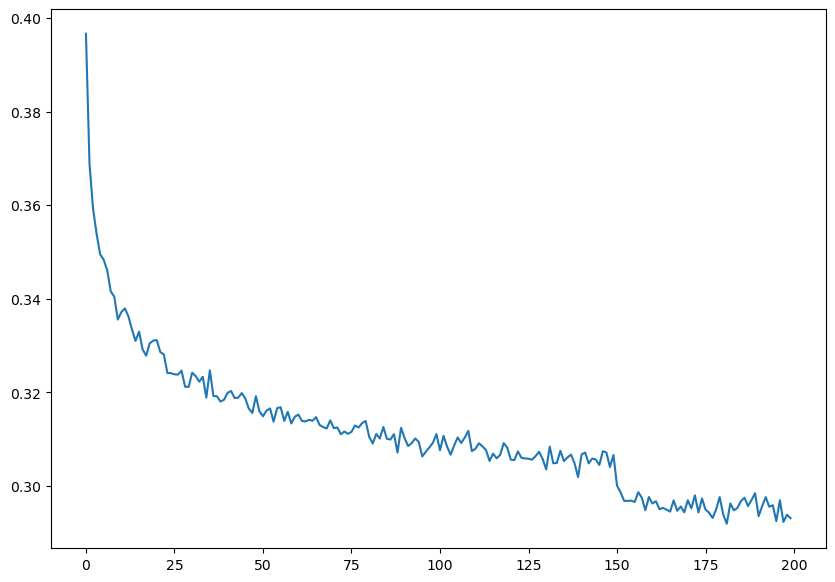

In [78]:
plt.figure(figsize=(10, 7))
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1));

In [79]:
split_loss('train')
split_loss('val')

train 1.9385297298431396
val 2.023508310317993


2.023508310317993

In [80]:
log_experiment(run_name="wavenet-hirearchical")

train 1.9385297298431396
val 2.023508310317993


![Alt wn3](images/tracking/wn3.png)

So wavenet hirearchical model has not improved much from wavenet-baseline(misleading name but bengio). This might be due to not utilizing the parameters properly in layers.

Also a batch norm bug in BatchNorm1d layer.

## BatchNorm1d bug

In [84]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Looking at batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  7, 18,  1],
        [ 0,  0,  0,  0,  0, 26,  1, 25],
        [ 0,  0,  0,  0,  0, 13,  5,  7],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [85]:
# Let's check the shapes
for layer in model.layers:
    print(f"Layer Name --> {layer.__class__.__name__} | shape --> {layer.out.shape}")

Layer Name --> Embedding | shape --> torch.Size([4, 8, 10])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 4, 20])
Layer Name --> Linear | shape --> torch.Size([4, 4, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 4, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 4, 68])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 2, 136])
Layer Name --> Linear | shape --> torch.Size([4, 2, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 2, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 2, 68])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 136])
Layer Name --> Linear | shape --> torch.Size([4, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 68])
Layer Name --> Linear | shape --> torch.Size([4, 27])


If we look at the batch norm shapes, it's (4, 4, 68)

In [86]:
# Running mean shape
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

What we've essentially is 4 parallel means across 68 hidden neurons. 
This is because, we've written batchnorm for a single dimension

In [89]:
e = torch.randn(32, 4, 68)
e_mean = e.mean(0, keepdim=True)
e_mean.shape

torch.Size([1, 4, 68])

In [90]:
e_var = e.var(0, keepdim=True)
e_var.shape

torch.Size([1, 4, 68])

In [91]:
ehat = (e - e_mean) / torch.sqrt(e_var + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [94]:
# Let's fix it in batch norm layer
# This deviates from torch.BatchNorm1d params(N, C, L) where C is the first dimension, but we consider the last dimension in out implementation
# So N, C, L in torch will be N, L, C in our implemenation below
# torch calculates mean for 0 and 2, we calculate for 0 and 1
# torch.mean also accepts a tuple of dimenstions

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):

        if x.ndim == 2:
            dim = 0
        elif x.ndim == 3:
            dim = (0, 1)

        if self.training:
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


In [109]:
# Shape 4, 4, 20 in flatten
n_embd = 10
n_hidden = 68 # 200 --> 68 to get 22397 parameters

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

22397


In [96]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Looking at batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 18,  1,  5],
        [ 0,  0,  0,  0,  0, 12,  5, 10],
        [ 0,  0,  0,  0,  0,  1, 13,  2],
        [ 0,  0,  0,  0,  3,  1, 14,  4]])

In [98]:
# Let's check the shapes
for layer in model.layers:
    print(f"Layer Name --> {layer.__class__.__name__} | shape --> {layer.out.shape}")

Layer Name --> Embedding | shape --> torch.Size([4, 8, 10])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 4, 20])
Layer Name --> Linear | shape --> torch.Size([4, 4, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 4, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 4, 68])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 2, 136])
Layer Name --> Linear | shape --> torch.Size([4, 2, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 2, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 2, 68])
Layer Name --> FlattenConsecutive | shape --> torch.Size([4, 136])
Layer Name --> Linear | shape --> torch.Size([4, 68])
Layer Name --> BatchNorm1d | shape --> torch.Size([4, 68])
Layer Name --> Tanh | shape --> torch.Size([4, 68])
Layer Name --> Linear | shape --> torch.Size([4, 27])


In [99]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [110]:
# Now let's run full loop
# Crushing way too much information (context size 8) way too fast
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000: 3.3085
  10000/ 200000: 1.9978
  20000/ 200000: 2.1031
  30000/ 200000: 2.0398
  40000/ 200000: 1.8591
  50000/ 200000: 1.8039
  60000/ 200000: 1.8312
  70000/ 200000: 1.7397
  80000/ 200000: 2.4996
  90000/ 200000: 2.0341
 100000/ 200000: 2.0187
 110000/ 200000: 1.6281
 120000/ 200000: 1.9661
 130000/ 200000: 1.7850
 140000/ 200000: 2.2481
 150000/ 200000: 2.1778
 160000/ 200000: 1.6187
 170000/ 200000: 1.5959
 180000/ 200000: 1.8502
 190000/ 200000: 1.9466


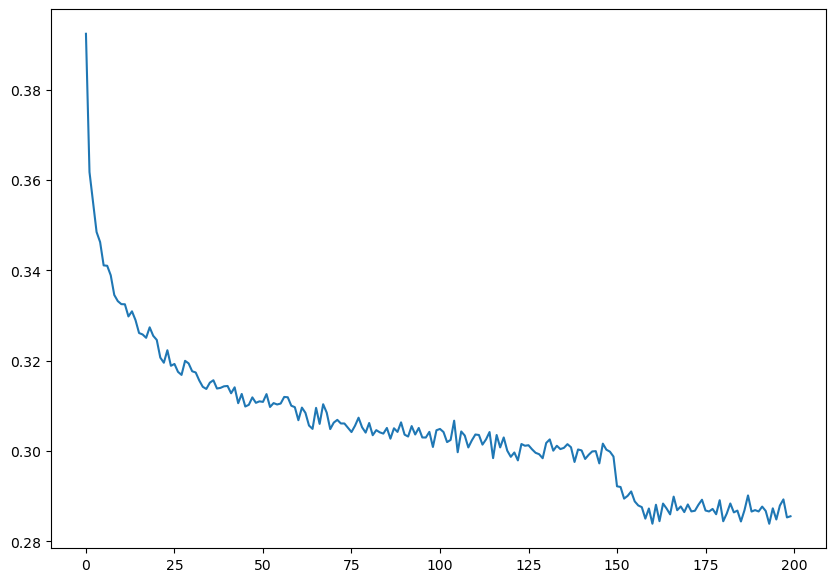

In [111]:
plt.figure(figsize=(10, 7))
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1));

In [112]:
split_loss('train')
split_loss('val')

train 1.912463903427124
val 2.019692897796631


2.019692897796631

In [113]:
log_experiment(run_name="wavenet-batchnorm-fix")

train 1.912463903427124
val 2.019692897796631


![Alt wn4](images/tracking/wn4.png)

We've improved loss by a tiny bit, becuase numerical stability is increased by having a single mean for 68 neurons instead of 4 mean and variances.

In [114]:
# Shape 4, 4, 20 in flatten
n_embd = 24
n_hidden = 128 # 200 --> 68 to get 22397 parameters

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of params

for p in parameters:
    p.requires_grad = True

76579


In [115]:
# Now let's run full loop
# Crushing way too much information (context size 8) way too fast
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0/ 200000: 3.3006
  10000/ 200000: 1.9534
  20000/ 200000: 1.7696
  30000/ 200000: 2.3993
  40000/ 200000: 2.2367
  50000/ 200000: 1.8171
  60000/ 200000: 2.1010
  70000/ 200000: 1.7803
  80000/ 200000: 1.8284
  90000/ 200000: 1.8613
 100000/ 200000: 2.2308
 110000/ 200000: 1.6233
 120000/ 200000: 1.3730
 130000/ 200000: 1.3858
 140000/ 200000: 1.7105
 150000/ 200000: 1.6554
 160000/ 200000: 1.8517
 170000/ 200000: 1.8735
 180000/ 200000: 1.9292
 190000/ 200000: 1.6202


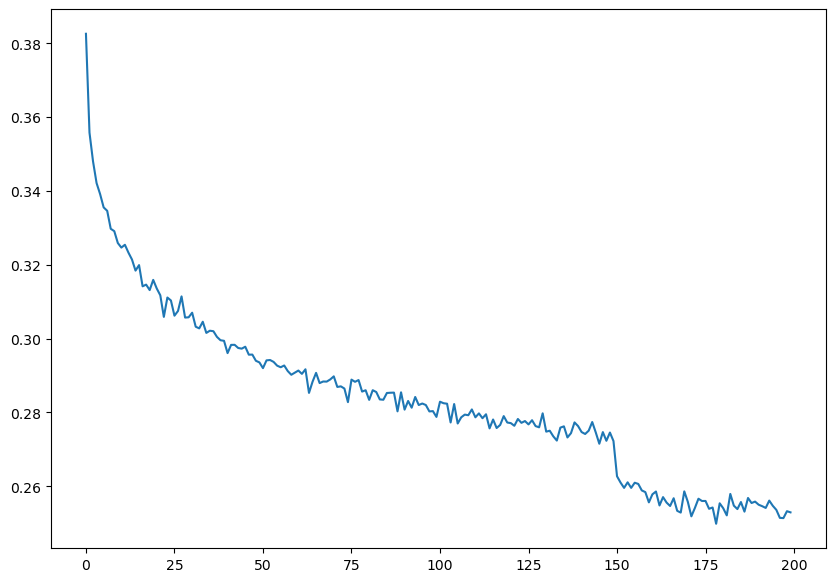

In [116]:
plt.figure(figsize=(10, 7))
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1));

In [117]:
split_loss('train')
split_loss('val')

train 1.768157720565796
val 1.9956563711166382


1.9956563711166382

In [118]:
log_experiment(run_name="wavenet-scaled-up")

train 1.768157720565796
val 1.9956563711166382


![Alt wn4](images/tracking/wn5.png)

# Further steps
1. Try implementing residual connections from wavenet paper
2. More experimenting, with experimental harness(val loss and more)